# Strain mapping with py4DSTEM

The code in this directory calculates and visualizes strain maps.

The procedure is divided into 7 steps, each in a single notebook:
1. **Get probe template**
2. Get the Bragg disks
3. Determine the diffraction shifts
4. Calculate lattice vectors
5. Refine lattice vectors
6. Calculate strain
7. Visualize strain maps

# Notebook 1: Get probe template

The aim here is to create a convolution kernel in the shape of the unscattered electron beam, which can then be used to identify the Bragg disks in each diffraction pattern of the datacube.  

Possible approaches include:
1. Use a scan region of the 4DSTEM datacube that was over vacuum (or perhaps thin amorphous support)
2. Use a separate 4DSTEM datacube take over vacuum
3. Create an artificial probe

Here, we demonstrate approach 1, proceeding as follows:

* Get average vacuum probe
    * Select an ROI over (nearly) vacuum
    * Find shifts of DPs within ROI relative to one reference DP
    * Register and average all DPs in ROI
* Create vacuum probe kernel
    * Mask probe outside of central disk
    * Get probe CoM and size
    * Normalize probe to integrate to 1
    * Subtract normalized 2D gaussian to get kernel integrating to 0
    * Center kernel in Fourier space (i.e. at corners of array)
* Save the vacuum probe kernel

### Import packages, load data

In [2]:
import py4DSTEM

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.morphology import binary_dilation as binary_dilation

from py4DSTEM.process.datastructure import DiffractionSlice, RealSlice

In [3]:
# # Load data
# fp = "/Users/Ben/Work/NCEM/Projects/py4DSTEM/sample_data/20180905_FePO4_unlithiated/Stack2_60x60+30nmss_spot 8_0p05s_CL=600_alpha=0p48_300kV_bin4.dm3"
# dc = py4DSTEM.readwrite.read_data(fp)
# dc.set_scan_shape(60,60)
# dc.data4D = np.roll(dc.data4D,-2,1) # Correct for acquisition wrap-around error

In [7]:
# Load data
#fp = "/home/ben/Data/20180905_FePO4_unlithiated/raw/Stack1_57x47+30nmss_spot 8_0p05s_CL=600_alpha=0p48_300kV_bin4.dm4"
fp = "/home/ben/Data/20190114_LiFePO4_100percentLithiated_secondbatch/Particle_5_Stack_1_130x40_ss30nm_0p035s_spot8_alpha=0p48_bin2_cl-600mm_300kV.dm4"
dc = py4DSTEM.readwrite.read_data(fp)
dc.set_scan_shape(40,130)
dc.data4D = np.roll(dc.data4D,-2,1) # Correct for acquisition wrap-around error

Reading file /home/ben/Data/20190114_LiFePO4_100percentLithiated_secondbatch/Particle_5_Stack_1_130x40_ss30nm_0p035s_spot8_alpha=0p48_bin2_cl-600mm_300kV.dm4...

/home/ben/Data/20190114_LiFePO4_100percentLithiated_secondbatch/Particle_5_Stack_1_130x40_ss30nm_0p035s_spot8_alpha=0p48_bin2_cl-600mm_300kV.dm4 is not a py4DSTEM file.  Reading with hyperspy...


### Get the average vacuum probe

In [10]:
# ROI

xmin,xmax=30,40
ymin,ymax=2,15

data = np.zeros_like(dc.data4D[:,:,0,0],dtype=bool)
data[xmin:xmax,ymin:ymax] = True

ROI = RealSlice(data,dc)

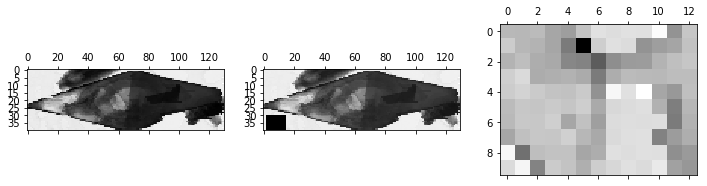

In [11]:
ave_im = np.average(dc.data4D,axis=(2,3))

fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(12,8))
ax1.matshow(ave_im,cmap='gray')
ax2.matshow(ave_im*(ROI.data2D==False),cmap='gray')
ax3.matshow(ave_im[ROI.data2D].reshape(xmax-xmin,ymax-ymin),cmap='gray')
plt.show()

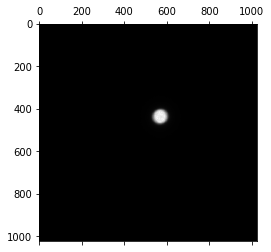

In [12]:
# Average DP, unshifted

DP_ave_unshifted = np.average(dc.data4D[ROI.data2D,:,:],axis=(0))

fig,ax=plt.subplots()
ax.matshow(DP_ave_unshifted,cmap='gray')
plt.show()

In [13]:
# Get average shift-corrected diffraction pattern

length = ROI.data2D.sum()
ref_DP = dc.data4D[ROI.data2D,:,:][0]

for n in range(1,length):
    curr_DP = dc.data4D[ROI.data2D,:,:][n]
    
    xshift,yshift = py4DSTEM.process.utils.get_shift(ref_DP, curr_DP)
    curr_DP_shifted = py4DSTEM.process.utils.get_shifted_ar(curr_DP,xshift,yshift)
    ref_DP = ref_DP*(n-1)/n + curr_DP_shifted/n

probe_template = DiffractionSlice(ref_DP,dc)

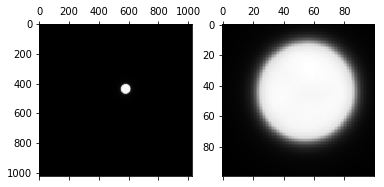

In [14]:
# Get (initial) center of mass
# Show shifted, averaged DP

xCoM_init,yCoM_init = py4DSTEM.process.utils.get_CoM(probe_template.data2D)

fig,(ax1,ax2)=plt.subplots(1,2)
ax1.matshow(probe_template.data2D,cmap='gray')
ax2.matshow(probe_template.data2D[int(xCoM_init)-50:int(xCoM_init)+50,int(yCoM_init)-50:int(yCoM_init)+50])
plt.show()

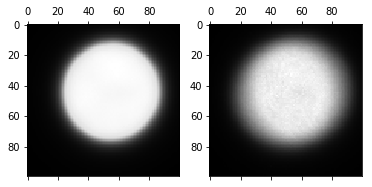

In [15]:
# Compare shifted to unshifted ave DPs

xCoM_unshifted,yCoM_unshifted = py4DSTEM.process.utils.get_CoM(DP_ave_unshifted)

fig,(ax1,ax2)=plt.subplots(1,2)
ax1.matshow(probe_template.data2D[int(xCoM_init)-50:int(xCoM_init)+50,int(yCoM_init)-50:int(yCoM_init)+50])
ax2.matshow(DP_ave_unshifted[int(xCoM_unshifted)-50:int(xCoM_unshifted)+50,int(yCoM_unshifted)-50:int(yCoM_unshifted)+50])
plt.show()

### Create vacuum probe kernel

In [16]:
# Mask probe outside of central disk

mask_thresh = 0.2
mask_expansion = 12

mask = ref_DP > np.max(probe_template.data2D)*mask_thresh
mask = binary_dilation(mask,iterations=mask_expansion)

#maskDist = 0.5 + 0.5*erf(maskShift + (bwdist(~maskRound) - bwdist(bwmorph(maskRound,'dilate',1))) / (0.5*maskWidth));

probe_template.data2D = probe_template.data2D*mask

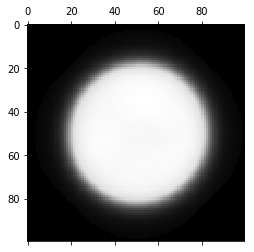

Mask alters CoM by 7.431854928215313 pixels.


In [17]:
# Get CoM
# Compare to CoM without mask

xCoM,yCoM = py4DSTEM.process.utils.get_CoM(probe_template.data2D)

fig,ax=plt.subplots()
ax.matshow(probe_template.data2D[int(xCoM)-50:int(xCoM)+50,int(yCoM)-50:int(yCoM)+50])
plt.show()

print("Mask alters CoM by {} pixels.".format(np.sqrt((yCoM-yCoM_init)**2+(xCoM-xCoM_init)**2)))

In [18]:
# Get probe size

qy,qx = np.meshgrid(np.arange(dc.Q_Ny),np.arange(dc.Q_Nx))
q2 = (qx-xCoM)**2 + (qy-yCoM)**2
qstd2 = np.sum(q2*probe_template.data2D*mask) / np.sum(probe_template.data2D)

In [29]:
# Normalize probe to one
# Subtract off gaussian, to yield a kernel which integrates to zero
sigma_probe_scale = 2.5

probe_template_norm = probe_template.data2D/np.sum(probe_template.data2D)
subtr_gaussian = np.exp(-q2 / (2*qstd2*sigma_probe_scale**2))
subtr_gaussian = subtr_gaussian/np.sum(subtr_gaussian)
probe_kernel = probe_template_norm - subtr_gaussian

probe_kernel = py4DSTEM.process.datastructure.DiffractionSlice(probe_kernel, dc, name='probe_kernel')

print("Probe kernel sums to {}.".format(np.sum(probe_kernel.data2D)))

Probe kernel sums to -7.472758983586533e-16.


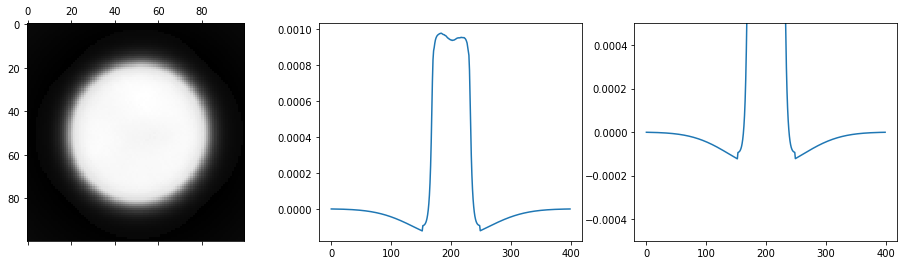

In [30]:
# Plot line profile through probe_kernel

#xCoM,yCoM = py4DSTEM.process.utils.get_CoM(probe_template.data2D)
rad=200
width=2

line_profile = np.sum(probe_kernel.data2D[int(xCoM)-rad:int(xCoM)+rad,int(yCoM)-width:int(yCoM)+width],axis=(1))

fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(16,4))
ax1.matshow(probe_kernel.data2D[int(xCoM)-50:int(xCoM)+50,int(yCoM)-50:int(yCoM)+50])
ax2.plot(np.arange(len(line_profile)),line_profile)
ax3.plot(np.arange(len(line_profile)),line_profile)
ax3.set_ylim(-0.0005,0.0005)
plt.show()

In [31]:
# Shift probe kernel to center, then to corners
probe_kernel.data2D = py4DSTEM.process.utils.get_shifted_ar(probe_kernel.data2D,-xCoM,-yCoM)

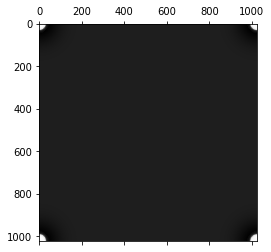

In [32]:
fig,ax=plt.subplots()
ax.matshow(probe_kernel.data2D,cmap='gray')
plt.show()

### Save the vacuum probe kernel

In [30]:
# # Save

# savepath = "/Users/Ben/Work/NCEM/Projects/py4DSTEM/sample_data/20180905_FePO4_unlithiated/processing/vacuum_probe_kernel.h5"
# py4DSTEM.readwrite.save_dataobject(probe_kernel,savepath)

In [31]:
# Save

savepath = "/home/ben/Data/20180905_FePO4_unlithiated/processing/vacuum_probe_kernel.h5"
py4DSTEM.readwrite.save_dataobject(probe_kernel,savepath)

Creating file /home/ben/Data/20180905_FePO4_unlithiated/processing/vacuum_probe_kernel.h5...
Writing metadata...
Done.


In [33]:
savepath = "/home/ben/Data/20190114_LiFePO4_100percentLithiated_secondbatch/processing/vacuum_probe_kernel.h5"
py4DSTEM.readwrite.save_dataobject(probe_kernel,savepath)

Creating file /home/ben/Data/20190114_LiFePO4_100percentLithiated_secondbatch/processing/vacuum_probe_kernel.h5...
Writing metadata...
Done.
